<a href="https://colab.research.google.com/github/tobp03/FreeCodeCamp/blob/main/Scripts/Augmeneted_Video_%2B_MediaPipe_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 30.6 MB/s eta 0:00:00


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
import random
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import time
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [ ]:
def video_to_uint8array(file_path):
    # Open the video file
    cap = cv2.VideoCapture(file_path)

    # Check if the video file is opened successfully
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return
    frames = []
    while True:
        ret, frame = cap.read()
        # If the video has finished or an error occurs, break the loop
        if not ret:
            break
        frame_array = np.array(frame)
        #Set output video resolution
        frame_array = cv2.resize(frame_array, (192, 144))
        frames.append(frame_array)


    # Release the video capture object and close the OpenCV window
    cap.release()
    cv2.destroyAllWindows()
    return np.array(frames)

In [ ]:
def resize_frame(original_image,scale_factor = 0.7):
  new_width = int(original_image.shape[1] * scale_factor)
  new_height = int(original_image.shape[0] * scale_factor)
  resized_image = cv2.resize(original_image, (new_width, new_height))
  x_offset = (abs(original_image.shape[1] - new_width)) // 2
  y_offset = (abs(original_image.shape[0] - new_height)) // 2
  if scale_factor < 1:
    black_frame = np.zeros((original_image.shape[0], original_image.shape[1], 3), dtype=np.uint8)
    black_frame[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_image
    frame=black_frame
  elif scale_factor == 1:
    frame=resized_image
  else:
    frame=resized_image[y_offset:-y_offset + new_height, x_offset:-x_offset + new_width][0:original_image.shape[0],0:original_image.shape[1]]
  return frame
def translate_image(image, x_translation, y_translation):
    rows, cols, channels = image.shape

    # Define the translation matrix
    translation_matrix = np.float32([[1, 0, x_translation], [0, 1, y_translation]])

    # Apply the translation to the image
    translated_image = cv2.warpAffine(image, translation_matrix, (cols, rows))
    return translated_image

def augment_video(video,scale_factor,translate_x,translate_y):
  frames=[]
  for i in range(0,video.shape[0]):
    frame = translate_image(resize_frame(video[i],scale_factor),translate_x,translate_y)
    frames.append(frame)
  return np.array(frames)


In [ ]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [ ]:
def extract_to_row(results):
    pose_features = ['x','y','z','visibility']
    hand_features = ['x','y','z']
    features= []
    values = []
    if hasattr(results.pose_landmarks, 'landmark'):
        for i,value in enumerate(results.pose_landmarks.landmark):
            features.extend([f'pose_x{i}', f'pose_y{i}',f'pose_z{i}',f'pose_vis{i}'])
            values.extend([value.x,value.y,value.z,value.visibility])
    else:
        for i in range(0,33):
            features.extend([f'pose_x{i}', f'pose_y{i}',f'pose_z{i}',f'pose_vis{i}'])
            values.extend([0,0,0,0])

    if hasattr(results.left_hand_landmarks, 'landmark'):
        for i,value in enumerate(results.left_hand_landmarks.landmark):
            features.extend([f'Lhand_x{i}', f'Lhand_y{i}',f'Lhand_z{i}'])
            values.extend([value.x,value.y,value.z])
    else:
        for i in range(0,21):
            features.extend([f'Lhand_x{i}', f'Lhand_y{i}',f'Lhand_z{i}'])
            values.extend([0,0,0])


    if hasattr(results.right_hand_landmarks, 'landmark'):
        for i,value in enumerate(results.right_hand_landmarks.landmark):
            features.extend([f'Rhand_x{i}', f'Rhand_y{i}',f'Rhand_z{i}'])
            values.extend([value.x,value.y,value.z])
    else:
        for i in range(0,21):
            features.extend([f'Rhand_x{i}', f'Rhand_y{i}',f'Rhand_z{i}'])
            values.extend([0,0,0])

    data = {feature:values[i] for i,feature in enumerate(features)}
    return data , values

In [ ]:
video = video_to_uint8array('/content/gdrive/MyDrive/Datasets/hello/video hello 29.mp4')

In [ ]:
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5,model_complexity=0) as holistic:

  image, results = mediapipe_detection(video[0], holistic)
  _ , data = extract_to_row(results)


In [ ]:
np.array(data).shape

(258,)

In [ ]:
# Path for exisiting data in google drive
gdrive_path = '/content/gdrive/MyDrive/Datasets'

# Recorded actions
actions = np.array(['hello', 'thanks', 'iloveyou','yes','no','help'])

# Amount of videos
no_sequences = 40

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [ ]:
#Create a new folder for augmented video
path = '/content/dataset'
for action in actions:
    try:
        path1 = os.path.join(path, str(action))
        os.mkdir(path1)
    except:
        print(f'The file \'{action}\' has be created already')
        pass

The file 'hello' has be created already
The file 'thanks' has be created already
The file 'iloveyou' has be created already
The file 'yes' has be created already
The file 'no' has be created already
The file 'help' has be created already


In [ ]:
#Split data into training and testing
X_train = []
y_train = []
X_test = []
y_test = []


for action in actions:
  X =[]
  y= []
  for seq in range(1,no_sequences):
    print(f"{action}, {seq}")
    file_path = os.path.join(gdrive_path, action, f'video {action} {seq}.mp4')
    temp_video=video_to_uint8array(file_path)

    print(temp_video.shape)
    X.append(temp_video)
    y.append(action)
  X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size=0.2, shuffle=False)
  X_train.extend(X_train_t)
  y_train.extend(y_train_t)
  X_test.extend(X_test_t)
  y_test.extend(y_test_t)

hello, 1
(30, 144, 192, 3)
hello, 2
(30, 144, 192, 3)
hello, 3
(30, 144, 192, 3)
hello, 4
(30, 144, 192, 3)
hello, 5
(30, 144, 192, 3)
hello, 6
(30, 144, 192, 3)
hello, 7
(30, 144, 192, 3)
hello, 8
(30, 144, 192, 3)
hello, 9
(30, 144, 192, 3)
hello, 10
(30, 144, 192, 3)
hello, 11
(30, 144, 192, 3)
hello, 12
(30, 144, 192, 3)
hello, 13
(30, 144, 192, 3)
hello, 14
(30, 144, 192, 3)
hello, 15
(30, 144, 192, 3)
hello, 16
(30, 144, 192, 3)
hello, 17
(30, 144, 192, 3)
hello, 18
(30, 144, 192, 3)
hello, 19
(30, 144, 192, 3)
hello, 20
(30, 144, 192, 3)
hello, 21
(30, 144, 192, 3)
hello, 22
(30, 144, 192, 3)
hello, 23
(30, 144, 192, 3)
hello, 24
(30, 144, 192, 3)
hello, 25
(30, 144, 192, 3)
hello, 26
(30, 144, 192, 3)
hello, 27
(30, 144, 192, 3)
hello, 28
(30, 144, 192, 3)
hello, 29
(30, 144, 192, 3)
hello, 30
(30, 144, 192, 3)
hello, 31
(30, 144, 192, 3)
hello, 32
(30, 144, 192, 3)
hello, 33
(30, 144, 192, 3)
hello, 34
(30, 144, 192, 3)
hello, 35
(30, 144, 192, 3)
hello, 36
(30, 144, 192, 3)
h

In [ ]:
X_train = np.stack(X_train,axis=0)
X_test = np.stack(X_test,axis=0)
y_train = np.array(y_train)
y_test = np.array(y_test)



In [ ]:
X_train.shape, X_test.shape , y_train.shape, y_test.shape

((186, 30, 144, 192, 3), (48, 30, 144, 192, 3), (186,), (48,))

In [ ]:
def vidarray_to_keyMP(video):
  temp = []
  with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5,model_complexity=0) as holistic:
    for frame_num in range(video.shape[0]):
      _, results = mediapipe_detection(video[frame_num], holistic)
      _, data=extract_to_row(results)
      temp.append(data)
    return np.array(temp)

array([[[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       [[253, 253, 251],
        [253, 253, 251],
        [253, 253, 251],
        ...,
        [250, 253, 251],
        [250, 253, 251],
        [250, 253, 251]],

       [[253, 253, 251],
        [253, 253, 251],
        [253, 253, 253],
        ...,
        [251, 253, 251],
        [251, 253, 251],
        [251, 253, 251]],

       ...,

       [[167, 133,  98],
        [167, 125,  94],
        [168, 130,  98],
        ...,
        [255, 252, 188],
        [254, 239, 176],
        [252, 230, 172]],

       [[169, 130,  96],
        [175, 127,  92],
        [165, 129,  96],
        ...,
        [254, 249, 188],
        [254, 249, 187],
        [253, 241, 182]],

       [[166, 125,  93],
        [175, 129,  93],
        [193, 147, 110],
        ...,
        [253, 250, 198],
        [251, 243, 189],
        [251, 247, 192]]], dtype=uint8)
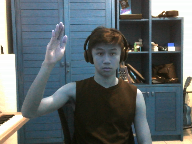

In [ ]:
video[0]

In [ ]:
vidarray_to_keyMP(video).shape

(30, 258)

In [ ]:
video.shape

(30, 144, 192, 3)

In [ ]:
X_train.shape

(187, 30, 144, 192, 3)

In [ ]:
2*31-1

61

In [ ]:
y_train[93:125]

array(['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'yes', 'yes', 'no'], dtype='<U8')

In [ ]:
#Augment training data then apply mediapipe

action_videos = 80 #Augmented video for each actions that will be generated
X_temp =[]
y_temp= []

for index , action in enumerate(actions):
  for i in range(0,action_videos):
    print(f"{action} , {i}")
    sequence = random.randint(index*31, (index+1)*31-1)
    scale_factor = random.uniform(0.5, 1.2)

    if scale_factor < 1:
      translate_x = random.randint(-30, 30)
      translate_y = random.randint(-30, 30)
      video_agt = augment_video(X_train[sequence],scale_factor,translate_x,translate_y)
    else:
      video_agt = augment_video(X_train[sequence],scale_factor,0,0)
    video_agt = vidarray_to_keyMP(video_agt)
    X_temp.append(video_agt)
    y_temp.append(action)

X_temp = np.stack(X_temp,axis=0)
y_temp = np.array(y_temp)
X_train = X_temp
y_train = y_temp
del X_temp, y_temp

hello , 0
hello , 1
hello , 2
hello , 3
hello , 4
hello , 5
hello , 6
hello , 7
hello , 8
hello , 9
hello , 10
hello , 11
hello , 12
hello , 13
hello , 14
hello , 15
hello , 16
hello , 17
hello , 18
hello , 19
hello , 20
hello , 21
hello , 22
hello , 23
hello , 24
hello , 25
hello , 26
hello , 27
hello , 28
hello , 29
hello , 30
hello , 31
hello , 32
hello , 33
hello , 34
hello , 35
hello , 36
hello , 37
hello , 38
hello , 39
hello , 40
hello , 41
hello , 42
hello , 43
hello , 44
hello , 45
hello , 46
hello , 47
hello , 48
hello , 49
hello , 50
hello , 51
hello , 52
hello , 53
hello , 54
hello , 55
hello , 56
hello , 57
hello , 58
hello , 59
hello , 60
hello , 61
hello , 62
hello , 63
hello , 64
hello , 65
hello , 66
hello , 67
hello , 68
hello , 69
hello , 70
hello , 71
hello , 72
hello , 73
hello , 74
hello , 75
hello , 76
hello , 77
hello , 78
hello , 79
thanks , 0
thanks , 1
thanks , 2
thanks , 3
thanks , 4
thanks , 5
thanks , 6
thanks , 7
thanks , 8
thanks , 9
thanks , 10
thanks ,

In [ ]:
# Save array to drive
path = '/content/gdrive/MyDrive/y_train.npy'

# Save the array to a binary file in your Google Drive
np.save(path, y_train)

In [ ]:
#Apply media pipe to
X_temp =[]
y_temp= []

for index , action in enumerate(actions):
  for i in range(0,action_videos):
    print(f"{action} , {i}")
    sequence = random.randint(index*31, (index+1)*31-1)
    scale_factor = random.uniform(0.5, 1.2)

    if scale_factor < 1:
      translate_x = random.randint(-30, 30)
      translate_y = random.randint(-30, 30)
      video_agt = augment_video(X_train[sequence],scale_factor,translate_x,translate_y)
    else:
      video_agt = augment_video(X_train[sequence],scale_factor,0,0)
    video_agt = vidarray_to_keyMP(video_agt)
    X_temp.append(video_agt)
    y_temp.append(action)

X_temp = np.stack(X_temp,axis=0)
y_temp = np.array(y_temp)
X_train = X_temp
y_train = y_temp
del X_temp, y_temp